# Lab 2: Benchmarking DCNN on CPU and GPU

In this assignment, we will benchmark convolution algorithms on an NVIDIA K80 datacenter GPU and on a CPU using PyTorch. This will serve as a demonstration regarding the selection of CPU vs GPU and the importance of benchmarking tools.

This lab consists of the following steps:

* Creating a mini MLPerf suitable for Google Collab
* Run and benchmark DCNN inference on CPU on multiple models
* Run and benchmark DCNN inference on GPU on multiple models
* Explore effects of batch size on performance

You may wish to read through the entire assignment before starting work.

## Overview

In this assignment, you will benchmark the performance and accuracy of VGG16, GoogLeNet, ResNet and AlexNet inference on both CPU and GPU.
Each of these models were presented in class. Refer to your classmates' presentation for each net.

We will first work through an example of loading a pretrained network and running inference on both CPU and GPU. Afterwards, you will benchmark CPU, GPU and batch size and communicate the results via writing and figures.


## Environment

In [ ]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
from torchvision import datasets, models, transforms
from pathlib import Path
import matplotlib.pyplot as plt

import time
print("PyTorch Version: ", torch.__version__)
print("Torchvision Version: ", torchvision.__version__)
!mkdir data
data_dir = Path('./data')
net_fn = Path('./net')

torch.manual_seed(0)
np.random.seed(0)

PyTorch Version:  1.12.1+cu113
Torchvision Version:  0.13.1+cu113


## Example Validation

### Dataset

You will use the 2012 ImageNet database. ImageNet consists of 1000 object classes, 1,281,167 training images, 50,000 validation images and 100,000 test images. You will use a subset of the 50,000 validation images. We will provide Google Drive folder with ImageNet. **Our ImageNet mirror cannot be used for any purposes outside this course**. If you wish to use ImageNet on other projects, please download ImageNet from the official source and agree to the terms of access [here](https://image-net.org/download.php).

Before running the below code, verify that the Shared Google Drive `penn-ese-5390-202230` is visible on your SEAS Google account.

Below mounts the Google Drive to `./drive`, copies necessary files to `./data`, instantiates the ImageNet dataset, and performs a data transform. This data transform can be used for all networks described in this lab.

In [ ]:
# Mount data directory to google drive
"""
Used the comments in code to execute the file
"""
# from google.colab import drive
# drive.mount('/content/drive')

# # Copy to local for faster extraction
# !cp /content/drive/Shareddrives/539/ILSVRC2012_img_val.tar ./data
# !cp /content/drive/Shareddrives/539/ILSVRC2012_devkit_t3.tar.gz ./data
# !cp /content/drive/Shareddrives/539/ILSVRC2012_devkit_t12.tar.gz ./data

# val_transform = transforms.Compose([
#     transforms.Resize(224),
#     transforms.CenterCrop(224),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# ])

# # Create validation dataset
# val_dataset = datasets.ImageNet('./data', split='val', transform=val_transform)

# # Create validation dataloader
# val_dataloader = torch.utils.data.DataLoader(val_dataset, num_workers=4)

# print(f'Number of validation images: {len(val_dataset)}')



# Mount data directory to google drive
from google.colab import drive
drive.mount('./drive')

# Copy to local for faster extraction
!cp drive/Shareddrives/penn-ese-5390-202230/ILSVRC2012_img_val.tar ./data
!cp drive/Shareddrives/penn-ese-5390-202230/ILSVRC2012_devkit_t3.tar.gz ./data
!cp drive/Shareddrives/penn-ese-5390-202230/ILSVRC2012_devkit_t12.tar.gz ./data

# Create transform to preprocess data
val_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Create validation dataset
val_dataset = datasets.ImageNet('./data', split='val', transform=val_transform)

# Create validation dataloader
val_dataloader = torch.utils.data.DataLoader(val_dataset, num_workers=4)

print(f'Number of validation images: {len(val_dataset)}')

Mounted at /content/drive
Number of validation images: 50000


### Loading Pre-trained Model

PyTorch's `torchvision` module provides the pretrained models that you will use in the lab. A list of models are found [here](https://pytorch.org/vision/stable/models.html#classification). The below code demonstrates how to load a pretrained model with weights. 

**NOTE:** Although we use different models, each model chosen is trained with the same data transform as instantiated above. If this wasn't the case, you could use `weights.transform()` to instantiate the transform that was used during model training. 

In [ ]:
# Get weights of pretrained model and instantiate model
model = models.resnet50(pretrained=True)
print(model) 
"""
remove the #
"""

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

'\nremove the #\n'

### Validating Pre-trained Model with CPU and GPU

We follow the same procedure as lab 1 to validate the pretrained model. However, we add an additional flag to enable GPU acceleration.
GPU acceleration is performed by sending the input tensor and the net weights to the GPU. If both the input tensor and net weights
are located on the GPU, the operation is performed on GPU. We use the `torch.device` to indicate CPU or GPU device.
There is a cost to memory movement between the CPU memory to the GPU memory and will be explored slightly in this lab.
There will be deeper discussion on the overheads of memory movement in future lectures.

In [ ]:
def validate_model(model, dataloader, device="cpu", n=None):
    model.eval()
    running_corrects = 0
    total = 0

    # Move model to device (CPU or GPU)
    # One time to amortize data movement
    dev = torch.device(device)
    model.to(dev)

    # Iterate over data stopping early if n is set
    for i, (inputs, labels) in enumerate(dataloader):
        if (n is not None and i >= n):
            break
        # Send inputs to device
        inputs = inputs.to(dev)

        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        
        """
        """
        temp = labels.data
        if(device=="cuda"):
          temp = temp.to(device="cuda")


        # Gather statistics
        running_corrects += torch.sum(predicted == temp)
        total += inputs.size()[0]       # get batch size

        if i % 200 == 199:
            acc = 100 * running_corrects.double() / total
            print(f'[{i + 1}] {acc:.4f}%')

    epoch_acc = 100 * running_corrects.double() / total

    return epoch_acc


print(f'Validation Finished. Final Accuracy: {validate_model(model, val_dataloader, device="cpu", n=1024):.4f}%') #change n to 1024
print(f'Validation Finished. Final Accuracy: {validate_model(model, val_dataloader, device="cuda", n=1024):.4f}%') #change n to 1024


[200] 87.0000%
[400] 83.2500%
[600] 86.8333%
[800] 88.5000%
[1000] 89.3000%
Validation Finished. Final Accuracy: 89.1602%
[200] 87.0000%
[400] 83.2500%
[600] 86.8333%
[800] 88.5000%
[1000] 89.3000%
Validation Finished. Final Accuracy: 89.1602%


### Benchmarking

There are a few common mistakes when benchmarking models on CPU and GPU. When benchmarking as part of this lab's assignment,
ensure that you are not making these mistakes. Part of this assignments grade is based on avoiding these three mistakes.

1. Sample size is too small. Do not benchmark the time of 1000 inferences. Instead, take the average of multiple tests of 1000 inferences.
Due to Colab's limited environment, we recommend running 1000 inferences *five* times.

2. Not warming up. CPU and GPU benchmarks should include a period of untimed inferences to warm up CPU and GPU microarchitecture.
Run benchmarks for *10 inferences* before timing the result.

3. Not blocking GPU execution. GPU execution is asynchronous to the CPU. That is, the CPU can continue running instructions as it waits for the GPU to complete its job.
Therefore, to get an accurate timing you must block the CPU to have it wait for GPU to finish. You can do this with `torch.cuda.synchronize()`.

At this point, you've learned how to use pretrained models and how to run inference on GPU. You will use these skills in the rest of the lab.

## Assignment

### Question 1

Instantiate a [Python dictionary](https://docs.python.org/3/tutorial/datastructures.html#dictionaries) with the four specified pretrained models:
`alexnet`, `googlenet`, `vgg16` and `resnet50`. Then, determine the top-1 accuracy of each model over 1000 inferences.

In [ ]:
# TODO Populate dictionary with pretrained models
modelss = {
          'alexnet': {'model': models.alexnet(pretrained=True)},
          'googlenet': {'model': models.googlenet(pretrained=True)},
          'vgg16': {'model': models.vgg16(pretrained=True)},
          'resnet50': {'model': models.resnet50(pretrained=True)}
}
for item in modelss.items():  
    temp = item[1]
    x = temp['model']
    print(f'Validation Finished. Final Accuracy: {validate_model(x, val_dataloader, device="cpu", n=1024):.4f}% for '+item[0]) #change n to 1024

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

[200] 66.5000%
[400] 65.5000%
[600] 68.8333%
[800] 71.5000%
[1000] 72.0000%
Validation Finished. Final Accuracy: 71.9727% for alexnet
[200] 82.5000%
[400] 77.7500%
[600] 81.5000%
[800] 83.2500%
[1000] 83.3000%
Validation Finished. Final Accuracy: 83.3008% for googlenet
[200] 85.5000%
[400] 82.0000%
[600] 84.8333%
[800] 87.0000%
[1000] 87.4000%
Validation Finished. Final Accuracy: 87.3047% for vgg16
[200] 87.0000%
[400] 83.2500%
[600] 86.8333%
[800] 88.5000%
[1000] 89.3000%
Validation Finished. Final Accuracy: 89.1602% for resnet50


### Question 2
Implement `benchmark_inference_v1` which outputs the average time in seconds to perform `n` inferences over `t` trials on CPU.

* Warm up the CPU with `warmup` inferences.
* Run and populate the average runtime for each model via `models[$MODEL_NAME][cpu_benchmark] = {1: $RUNTIME}`, replacing `$MODEL_NAME` with each model and `RUNTIME` with the average runtime across five trials with the model.
    * The `1` refers to batch size 1 which is what is being provided by the dataloader. We will populate other batch sizes in another question.
* Start timing after the warm-up loop has completed. Finish timing after the final inference has completed. Use `time.time()` to measure time.


In [ ]:
def benchmark_inference_v1(model, dataloader, n=None, trials=5, warmup=10):
    """ n = Number of inferences, trials = number of trials, warmup = number of warmup trials """
    # TODO Implement
    temp = modelss[model]
    x = temp['model']
    for i in range(warmup): #doing warmup on cpu
      validate_model(x, dataloader, device = "cpu", n=10)
    t_1 = time.time()
    validate_model(x, dataloader, device = "cpu", n=1024) # done only once as instruced in the Ed post #37
    t_2 = time.time()
    return t_2-t_1 # TODO Return inference time in seconds

for item in modelss.items():
    runtime = benchmark_inference_v1(item[0], val_dataloader, n=1024, trials=5, warmup=10) #calling benchmark_inference_v1
    print(f'{item[0]} -- CPU Runtime: {runtime}')
    print('---------------------------------------------')
    modelss[item[0]]['cpu_benchmark'] = {1: runtime}
"""
remove the #
"""

[200] 66.5000%
[400] 65.5000%
[600] 68.8333%
[800] 71.5000%
[1000] 72.0000%
alexnet -- CPU Runtime: 30.259344339370728
---------------------------------------------
[200] 82.5000%
[400] 77.7500%
[600] 81.5000%
[800] 83.2500%
[1000] 83.3000%
googlenet -- CPU Runtime: 71.79854893684387
---------------------------------------------
[200] 85.5000%
[400] 82.0000%
[600] 84.8333%
[800] 87.0000%
[1000] 87.4000%
vgg16 -- CPU Runtime: 264.6778562068939
---------------------------------------------
[200] 87.0000%
[400] 83.2500%
[600] 86.8333%
[800] 88.5000%
[1000] 89.3000%
resnet50 -- CPU Runtime: 164.11905217170715
---------------------------------------------


'\nremove the #\n'

### Question 3
Implement `benchmark_inference_v2` which includes an additional `device` parameter to select CPU or GPU. We save the GPU results in the `gpu_benchmark` key.
Ensure to use `torch.cuda.synchronize()` to block the computation **after** all inferences within a test have finished before ending the timer.

In [ ]:
def benchmark_inference_v2(model, dataloader, n=None, trials=5, warmup=10, device = "cpu"):
    """ n = Number of inferences, trials = number of trials, warmup = number of warmup trials, device="cpu" or "cuda" """
    # TODO Implement
    temp = modelss[model]
    t = []
    x = temp['model']
    if(device=='cpu'): #checking if input parameter of device is cpu
      for i in range(warmup): # doing warmup for cpu
        validate_model(x, dataloader, device = "cpu", n=10)
      t_1 = time.time()
      validate_model(x, dataloader, device = "cpu", n=1024) # done only once as instruced in the Ed post #37
      t_2 = time.time()
      t_return = t_2-t_1
    if(device=='cuda'):#checking if input parameter of device is cpu
      for i in range(warmup):
        validate_model(x, dataloader, device = "cuda", n=10) #doing warmup for gpu
      for i in range(trials): #doing 5 trials 
        t_1 = time.time()
        validate_model(x, dataloader, device = "cuda", n=1024) #executing on gpu
        torch.cuda.synchronize() #stopping all calculations
        t_2 = time.time()
        t_diff = t_2-t_1
        t.append(t_diff)
      num = (sum(t))
      den = float(len(t))
      tavg = num/den #calculating average of 5 values
      t_return = tavg
    return t_return # TODO Return inference time in seconds


for item in modelss.items():
    runtime = benchmark_inference_v2(item[0], val_dataloader, n=1024, trials=5, warmup=10, device="cuda") #calling v2
    print(f'{item[0]} -- GPU Runtime: {runtime}')
    modelss[item[0]]['gpu_benchmark_q2'] = {1: runtime}


[200] 66.5000%
[400] 65.5000%
[600] 68.8333%
[800] 71.5000%
[1000] 72.0000%
[200] 66.5000%
[400] 65.5000%
[600] 68.8333%
[800] 71.5000%
[1000] 72.0000%
[200] 66.5000%
[400] 65.5000%
[600] 68.8333%
[800] 71.5000%
[1000] 72.0000%
[200] 66.5000%
[400] 65.5000%
[600] 68.8333%
[800] 71.5000%
[1000] 72.0000%
[200] 66.5000%
[400] 65.5000%
[600] 68.8333%
[800] 71.5000%
[1000] 72.0000%
alexnet -- GPU Runtime: 5.121129989624023
[200] 82.5000%
[400] 77.7500%
[600] 81.5000%
[800] 83.2500%
[1000] 83.3000%
[200] 82.5000%
[400] 77.7500%
[600] 81.5000%
[800] 83.2500%
[1000] 83.3000%
[200] 82.5000%
[400] 77.7500%
[600] 81.5000%
[800] 83.2500%
[1000] 83.3000%
[200] 82.5000%
[400] 77.7500%
[600] 81.5000%
[800] 83.2500%
[1000] 83.3000%
[200] 82.5000%
[400] 77.7500%
[600] 81.5000%
[800] 83.2500%
[1000] 83.3000%
googlenet -- GPU Runtime: 12.17155418395996
[200] 85.5000%
[400] 82.0000%
[600] 84.8333%
[800] 87.0000%
[1000] 87.4000%
[200] 85.5000%
[400] 82.0000%
[600] 84.8333%
[800] 87.0000%
[1000] 87.4000%
[2

'\nremove the #\n'

### Question 4
Implement `benchmark_inference_v3` which includes another parameter called `batch_size`. Increasing the batch size allows more computation to be offloaded to the GPU to amortize memory movement. Batch size is determined by the dataloader. To change the batch size, create one dataloader with the largest batch size. Then, for smaller batch sizes, divide the tensor into multiple batches. Batch size is the first dimension of a tensor. One example would be to take a 32-batch tensor created by a dataloader and divide the tensor into two tensors of batch 16 via `tensor[0:8]` and `tensor[8:16]`.

For both CPU and GPU, measure the performance with batch size `{1, 2, 4, 8, 16, 32}`. Ensure that the total number of inferences (batch_size * num_batches) is 1024.

In [ ]:
def benchmark_inference_v3(model, dataloader, n=None, trials=5, warmup=10, device="cpu", batch_size=1):
    """ n = Number of inferences, trials = number of trials, warmup = number of warmup trials, device="cpu" or "cuda" """
    temp = modelss[model]
    t = []
    x = temp['model']
    if(device=='cpu'):
      for i in range(warmup): #wawrming up for cpu
        validate_model(x, dataloader, device = "cpu", n=10)
      t_1 = time.time()
      validate_model(x, dataloader, device = "cpu", n=1024/batch_size) # done only once as instruced in the Ed post #37
      t_2 = time.time()
      t_return = t_2-t_1
    if(device=='cuda'):
      for i in range(warmup): #warming up for gpu
        validate_model(x, dataloader, device = "cuda", n=10)
      for i in range(trials):
        t_1 = time.time()
        validate_model(x, dataloader, device = "cuda", n=1024/batch_size) #executing on gpu
        torch.cuda.synchronize() #waiting for all calc to finish
        t_2 = time.time()
        t_diff = t_2-t_1
        t.append(t_diff) #appending to a list for 5 inference times
      num = (sum(t))
      den = float(len(t))
      tavg = num/den
      t_return = tavg #calculating the average
    return t_return # TODO Return inference time in seconds

batch_list = [1,2,4] # alist with all the batch size values
val_dataloader_1 = torch.utils.data.DataLoader(val_dataset, num_workers=4, batch_size = 1) # initializing dataloader for batch_size = 1
val_dataloader_2 = torch.utils.data.DataLoader(val_dataset, num_workers=4, batch_size = 2) # initializing dataloader for batch_size = 2
val_dataloader_4 = torch.utils.data.DataLoader(val_dataset, num_workers=4, batch_size = 4) # initializing dataloader for batch_size = 4

y_alexnet_q3_cpu = []
y_alexnet_q3_gpu = []
y_googlenet_q3_cpu = []
y_googlenet_q3_gpu = []
y_vgg16_q3_cpu = []
y_vgg16_q3_gpu = []
y_resnet50_q3_cpu = []
y_resnet50_q3_gpu = []


for item in modelss.items():
    # TODO loop into each batch size and add batch size and timing to the 'cpu_benchmark' or `gpu_benchmark` key
    for each in batch_list:

      if(each==1):
        val_dataloader = val_dataloader_1
      if(each==2):
        val_dataloader = val_dataloader_2
      if(each==4):
        val_dataloader = val_dataloader_4


      runtime = benchmark_inference_v3(item[0], val_dataloader, n=1024/each, trials=5, warmup=10, device="cpu", batch_size = each)
      print(item[0]+"---cpu---"+str(each))
      print(f'{item[0]} -- CPU Runtime: {runtime}')
      if(item[0]=='alexnet'):
        y_alexnet_q3_cpu.append(runtime)
      if(item[0]=='googlenet'):
        y_googlenet_q3_cpu.append(runtime)
      if(item[0]=='vgg16'):
        y_vgg16_q3_cpu.append(runtime)
      if(item[0]=='resnet50'):
        y_resnet50_q3_cpu.append(runtime)
      
      runtime = benchmark_inference_v3(item[0], val_dataloader, n=1024/each, trials=5, warmup=10, device="cuda", batch_size = each)
      print(item[0]+"---gpu---"+str(each))
      print(f'{item[0]} -- GPU Runtime: {runtime}')
      if(item[0]=='alexnet'):
        y_alexnet_q3_gpu.append(runtime)
      if(item[0]=='googlenet'):
        y_googlenet_q3_gpu.append(runtime)
      if(item[0]=='vgg16'):
        y_vgg16_q3_gpu.append(runtime)
      if(item[0]=='resnet50'):
        y_resnet50_q3_gpu.append(runtime)
      
    print("-------------------------------------------")

[200] 66.5000%
[400] 65.5000%
[600] 68.8333%
[800] 71.5000%
[1000] 72.0000%
alexnet---cpu---1
alexnet -- CPU Runtime: 29.921441078186035
[200] 66.5000%
[400] 65.5000%
[600] 68.8333%
[800] 71.5000%
[1000] 72.0000%
[200] 66.5000%
[400] 65.5000%
[600] 68.8333%
[800] 71.5000%
[1000] 72.0000%
[200] 66.5000%
[400] 65.5000%
[600] 68.8333%
[800] 71.5000%
[1000] 72.0000%
[200] 66.5000%
[400] 65.5000%
[600] 68.8333%
[800] 71.5000%
[1000] 72.0000%
[200] 66.5000%
[400] 65.5000%
[600] 68.8333%
[800] 71.5000%
[1000] 72.0000%
alexnet---gpu---1
alexnet -- GPU Runtime: 5.211880111694336
[200] 65.5000%
[400] 71.5000%
alexnet---cpu---2
alexnet -- CPU Runtime: 31.428126573562622
[200] 65.5000%
[400] 71.5000%
[200] 65.5000%
[400] 71.5000%
[200] 65.5000%
[400] 71.5000%
[200] 65.5000%
[400] 71.5000%
[200] 65.5000%
[400] 71.5000%
alexnet---gpu---2
alexnet -- GPU Runtime: 4.3967667579650875
[200] 71.5000%
alexnet---cpu---4
alexnet -- CPU Runtime: 24.001430988311768
[200] 71.5000%
[200] 71.5000%
[200] 71.5000%


In [ ]:
batch_list_2 = [8,16,32] # alist with all the batch size values
val_dataloader_8 = torch.utils.data.DataLoader(val_dataset, num_workers=4, batch_size = 8) # initializing dataloader for batch_size = 8
val_dataloader_16 = torch.utils.data.DataLoader(val_dataset, num_workers=4, batch_size = 16) # initializing dataloader for batch_size = 16 
val_dataloader_32 = torch.utils.data.DataLoader(val_dataset, num_workers=4, batch_size = 32) # initializing dataloader for batch_size = 32

for item in modelss.items():
    # TODO loop into each batch size and add batch size and timing to the 'cpu_benchmark' or `gpu_benchmark` key
    for each in batch_list_2:

      if(each==8):
        val_dataloader = val_dataloader_8
      if(each==16):
        val_dataloader = val_dataloader_16
      if(each==32):
        val_dataloader = val_dataloader_32

      runtime = benchmark_inference_v3(item[0], val_dataloader, n=1024/each, trials=5, warmup=10, device="cpu", batch_size = each)
      print(item[0]+"---cpu---"+str(each))
      print(f'{item[0]} -- CPU Runtime: {runtime}')
      if(item[0]=='alexnet'):
        y_alexnet_q3_cpu.append(runtime)
      if(item[0]=='googlenet'):
        y_googlenet_q3_cpu.append(runtime)
      if(item[0]=='vgg16'):
        y_vgg16_q3_cpu.append(runtime)
      if(item[0]=='resnet50'):
        y_resnet50_q3_cpu.append(runtime)
      
      runtime = benchmark_inference_v3(item[0], val_dataloader, n=1024/each, trials=5, warmup=10, device="cuda", batch_size = each)
      print(item[0]+"---gpu---"+str(each))
      print(f'{item[0]} -- GPU Runtime: {runtime}')
      if(item[0]=='alexnet'):
        y_alexnet_q3_gpu.append(runtime)
      if(item[0]=='googlenet'):
        y_googlenet_q3_gpu.append(runtime)
      if(item[0]=='vgg16'):
        y_vgg16_q3_gpu.append(runtime)
      if(item[0]=='resnet50'):
        y_resnet50_q3_gpu.append(runtime)
      
    print("-------------------------------------------")

alexnet---cpu---8
alexnet -- CPU Runtime: 20.057504177093506
alexnet---gpu---8
alexnet -- GPU Runtime: 4.120543384552002
alexnet---cpu---16
alexnet -- CPU Runtime: 18.617366313934326
alexnet---gpu---16
alexnet -- GPU Runtime: 3.9702473640441895
alexnet---cpu---32
alexnet -- CPU Runtime: 18.837403535842896
alexnet---gpu---32
alexnet -- GPU Runtime: 4.682529258728027
-------------------------------------------
googlenet---cpu---8
googlenet -- CPU Runtime: 56.833922147750854
googlenet---gpu---8
googlenet -- GPU Runtime: 4.349655246734619
googlenet---cpu---16
googlenet -- CPU Runtime: 57.19657611846924
googlenet---gpu---16
googlenet -- GPU Runtime: 4.288650178909302
googlenet---cpu---32
googlenet -- CPU Runtime: 56.729775190353394
googlenet---gpu---32
googlenet -- GPU Runtime: 4.742257785797119
-------------------------------------------
vgg16---cpu---8
vgg16 -- CPU Runtime: 231.483740568161
vgg16---gpu---8
vgg16 -- GPU Runtime: 4.9529918193817135
vgg16---cpu---16
vgg16 -- CPU Runtime: 226

In [ ]:
print(y_alexnet_q3_cpu)
print(y_alexnet_q3_gpu)
print(y_googlenet_q3_cpu)
print(y_googlenet_q3_gpu)
print(y_vgg16_q3_cpu)
print(y_vgg16_q3_gpu)
print(y_resnet50_q3_cpu)
print(y_resnet50_q3_gpu)

[29.921441078186035, 31.428126573562622, 24.001430988311768, 20.057504177093506, 18.617366313934326, 18.837403535842896]
[5.211880111694336, 4.3967667579650875, 4.054377031326294, 4.120543384552002, 3.9702473640441895, 4.682529258728027]
[71.8490674495697, 65.46939611434937, 60.051111698150635, 56.833922147750854, 57.19657611846924, 56.729775190353394]
[12.209806680679321, 7.378557538986206, 5.152519941329956, 4.349655246734619, 4.288650178909302, 4.742257785797119]
[254.81329488754272, 249.03188681602478, 233.04874467849731, 231.483740568161, 226.94068455696106, 225.40706729888916]
[7.392147588729858, 6.194576740264893, 4.831026363372803, 4.9529918193817135, 4.68197226524353, 5.113512706756592]
[121.3091471195221, 111.00195741653442, 108.7712230682373, 98.73408079147339, 91.30316662788391, 94.86608791351318]
[10.879436492919922, 6.896838283538818, 4.707866239547729, 4.710188198089599, 4.640301036834717, 5.08993182182312]


### Question 5

Plot the CPU and GPU performance for each model according to the following specifications
* Use a line graph
* Label X and Y axis
* Title should be the name of the model and batch 1 accuracy of model
* X axis should be the batch size
* Y axis should be the `1/runtime`
* One series should be CPU the other series should be GPU

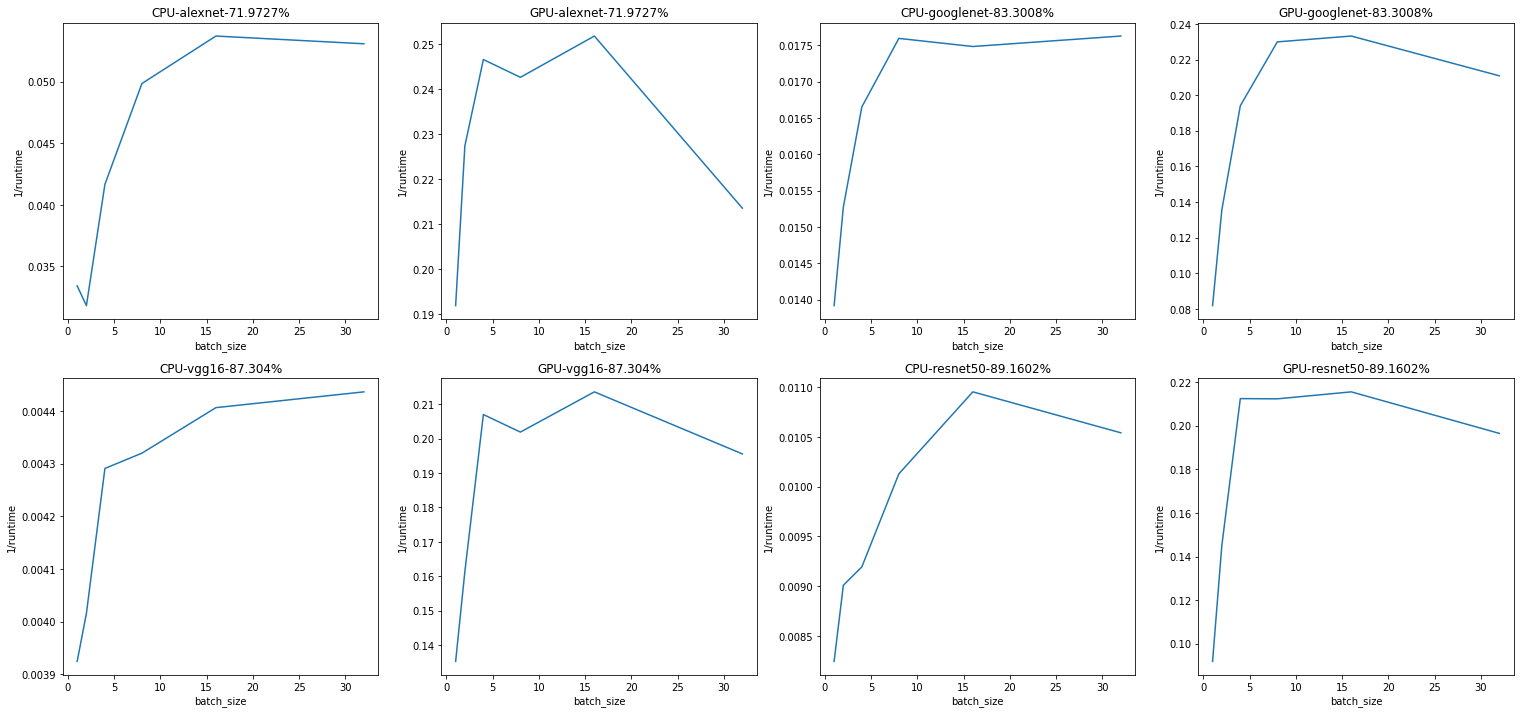

In [ ]:
import matplotlib.pyplot as plt
X = np.array([1,2,4,8,16,32])
Y1 = np.reciprocal(y_alexnet_q3_cpu)
Y2 = np.reciprocal(y_alexnet_q3_gpu)
Y3 = np.reciprocal(y_googlenet_q3_cpu)
Y4 = np.reciprocal(y_googlenet_q3_gpu)
Y5 = np.reciprocal(y_vgg16_q3_cpu)
Y6 = np.reciprocal(y_vgg16_q3_gpu)
Y7 = np.reciprocal(y_resnet50_q3_cpu)
Y8 = np.reciprocal(y_resnet50_q3_gpu)
fig = plt.figure(figsize=(26,12))
fig.add_subplot(2,4,1)
plt.title('CPU-alexnet-71.9727%')
plt.xlabel('batch_size')
plt.ylabel('1/runtime')
plt.plot(X,Y1)
fig.add_subplot(2,4,2)
plt.title('GPU-alexnet-71.9727%')
plt.xlabel('batch_size')
plt.ylabel('1/runtime')
plt.plot(X,Y2)
fig.add_subplot(2,4,3)
plt.title('CPU-googlenet-83.3008%')
plt.xlabel('batch_size')
plt.ylabel('1/runtime')
plt.plot(X,Y3)
fig.add_subplot(2,4,4)
plt.title('GPU-googlenet-83.3008%')
plt.xlabel('batch_size')
plt.ylabel('1/runtime')
plt.plot(X,Y4)
fig.add_subplot(2,4,5)
plt.title('CPU-vgg16-87.304%')
plt.xlabel('batch_size')
plt.ylabel('1/runtime')
plt.plot(X,Y5)
fig.add_subplot(2,4,6)
plt.title('GPU-vgg16-87.304%')
plt.xlabel('batch_size')
plt.ylabel('1/runtime')
plt.plot(X,Y6)
fig.add_subplot(2,4,7)
plt.title('CPU-resnet50-89.1602%')
plt.xlabel('batch_size')
plt.ylabel('1/runtime')
plt.plot(X,Y7)
fig.add_subplot(2,4,8)
plt.title('GPU-resnet50-89.1602%')
plt.xlabel('batch_size')
plt.ylabel('1/runtime')
plt.plot(X,Y8)


Write two paragraphs describing the results of the benchmarks.

* Paragraph 1: Describe relationships between CPU and GPU inference times within models. Why do these relationships exist?
<br>
The inference time is the amount of time it takes for a forward propagation to be more elaborate, the
amount of time that a Neural Network model takes to process the data given to it and make a
prediction. Since the models are already pretrained, we use the function validation_model to get
runtimes for the neural network models on CPU and GPU. This gives us the inference time for each
model.<br>
We can say that no matter the hardware, CPU or GPU the number of computations remain the same
across a single model. The reason that GPU is faster is because of higher throughput (more smaller
cores, etc. It’s obvious).<br>
Let’s say that CPU takes a time ‘t_cpu’ and the GPU roughly provides ‘X’ speedup.<br> We can formulate
‘t_gpu’ as –<br>
t_gpu = (1/X).(t_cpu).<br>
Since the number of computations remain the same for a single model whether on CPU or GPU, the
speedup factor will accelerate likewise. Hence the inference times between CPU and GPU are almost
proportional.
* Paragraph 2: Describe relationships between accuracy and performance across models. Why do these relationships exist?<br>
We notice a certain trend in the runtimes as in<br>
alexnet_runtime < googlenet_runtime < resnet50_runtime < vgg16_runtime<br>
We can attribute the first half of the above inequalities to the fact they have a similar number of layers
and that they all use convolution on the input provided to the model. But in the second half, resnet50
has more layers than vgg16 but has relatively less runtime. This is because of the differences in the
implementation of architecture. The vgg applies convolution to the full 224x224 image in the first two
layers. That is quite expensive in terms of computation. In resnet they use pooling and other techniques
to reduce the number of inputs from one layer to the subsequent layer. This reduces the computation or
more precisely the number of computations required.<br>Regarding accuracy, we try to minimize the loss function basically. For the first two models (alexnet,
googlenet) the depth and size of the models makes it such that there is a greater number of tunable
parameters for larger models. Hence better accuracy at the cost of higher computation. Resnet does it
better than vgg despite being larger due to skipping, pooling and other techniques used.


## Submission

Submit your completed Jupyter Notebook to canvas. Confirm you can run the entire file from head to toe without any errors, and keep all the cell output.